# FAIR maturity indicators for nanosafety

by  [Ammar Ammar](https://github.com/ammar257ammar), [Marvin Martens](https://github.com/marvinm2), [Laurent Winckers](https://github.com/laurent2207), [Serena Bonaretti](https://sbonaretti.github.io) and [Egon Willighagen](https://egonw.github.io), Maastricht University

---
### Use case

This notebook template considers an example use cases of data retrieval in the nanosafety field. For each case, we
- Execute data retrieval via API 
- Evaluate the FAIRness of the dataset

This template is derived from [this Jupyter notebook](https://github.com/sbonaretti/FAIR_metrics/blob/master/code/FAIR_assessment_2.ipynb) which has two example use cases.

The use-cases is:


<table>
<colgroup>
<col style="width: 20%" />
<col style="width: 80%" /> 
</colgroup>
    
  <tr>
    <th></th>
    <th>TiO<sub>2</sub></th>
  </tr>
    
  <tr>
    <th>Research question</th>
    <th>What does the database tell us about the safety of TiO<sub>2</sub>?</th>
  </tr>
  
  <tr>
    <th>Dataset</th>
    <th>eNanoMapper</th>
  </tr>
  
  <tr>
    <th>Repository</th>
      <th><a href="https://data.enanomapper.net/"/>data.enanomapper.net<a/></th>
  </tr>

</table>




Information about repository:
- **Repository: data.enanomapper.net**:
  - API: 
    - Documentation at http://ambit.sourceforge.net/enanomapper_usage.html
    - The API to query the repository is a rest API: https://enanomapper.github.io/API/
    - The API to get data is an export button for each dataset/bundle


---

### Calculating FAIR metrics

[Prerequisites:](#prerequisites)  
- [Imports](#imports)  
- [Variables](#variables)  
- [Functions](#functions)  

[Retrieving datasets:](#retrieval)  
- [Case: TEMPLATE: REPOSITORY](#Repository)

[Retrieving repositories in www.re3data.org](#Retrieving_repositories_in_www.re3data.org)


[FAIR assessment:](#metrics) 
- [F1. (Meta)data are assigned a globally unique and persistent identifier](#F1) 
- [F2. Data are described with rich metadata](#F2) 
- [F3. Metadata clearly and explicitly include the identifier of the data it describes](#F3)  
- [F4. (Meta)data are registered or indexed in a searchable resource](#F4) 
- [A1. (Meta)data are retrievable by their identifier using a standardized communications protocol](#A1)    
- [A1.1 The protocol is open, free, and universally implementable](#A11)   
- [A1.2 The protocol allows for an authentication and authorization procedure, where necessary](#A12)   
- [A2. Metadata are accessible, even when the data are no longer available](#A2)  
- [I1. (Meta)data use a formal, accessible, shared, and broadly applicable language for knowledge representation](#I1) 
- [I2. Metadata use vocabularies that follow FAIR principles](#I2)  
- [I3. (Meta)data include qualified references to other (meta)data](#I3)   
- [R1.1. (Meta)data are released with a clear and accessible data usage license](#R11)  
- [R1.2. (Meta)data are associated with detailed provenance](#R12)  
- [R1.3. (Meta)data meet domain-relevant community standards](#R13)

[FAIR assessment visualization](#visualization)

[Dependencies](#dependencies)

[Supplementary information](#supplementary_information)

---

<a name="prerequisites"></a>
### Prerequisites

<a name="imports"></a>
#### Imports

In [1]:
# import python packages
import os
import pandas as pd
import requests
import time
import xml.etree.ElementTree as ET
import json
from io import StringIO
import urllib.parse


In [ ]:
# Import R for visualization using ggplot2 - comment if used in mybinder, uncomment if used locally
#os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources' # put here your own R directory 

In [ ]:
%load_ext rpy2.ipython

<a name="variables"></a>
#### Variables

In [3]:
# re3Data API
re3data_repos    = "https://www.re3data.org/api/v1/repositories"
re3data_repo     = "https://www.re3data.org/api/v1/repository"
re3data_schema   = '{http://www.re3data.org/schema/2-2}' # in the metadata xml

In [4]:
# repository variables
repository_name  = []
repository_api   = []
dataset_download = []

# TEMPLATE: REPOSITORY
repository_name.append("data.enanomapper")
repository_api.append("https://api.ideaconsult.net/enanomapper/select?rows=1000&wt=json&q=")
dataset_download.append("https://api.ideaconsult.net/enanomapper/select?rows=1000&wt=json&q=")

In [5]:
# case names
case_names        = []
case_names.append("titanium_dioxide")

In [6]:
# search keywords
keywords = []

# TEMPLATE: REPOSITORY
kw = []
kw.append("TiO2")
keywords.append(kw)


In [7]:
# output variables used for FAIR assessment

request_status        = []
metadata_xml          = [] 
metadata_list         = [] # list of lists. Dimension: n_of_cases x 1. 
                           # Inside each cell, list of dimension 2 x N. First row is tags, second row is text of the xml output containing metadata
re3data_repo_root     = []
re3data_metadata_list = [] # same structure as metadata_list
n_of_found_keywords   = []
dataset_title         = []

F1  = []
F2  = []
F3  = []
F4  = []
A1  = []
A11 = []
A12 = []
A2  = []
I1  = []
I2  = []
I3  = []
R1  = []
R11 = []
R12 = []
R13 = []

<a name="functions"></a>
#### Functions

In [8]:
def find_repo_in_re3_data (repository_name):
    """
    It retrieves metadata about the input repository in re3data.org
    """
    
    # contact the re3data
    re3data_r = requests.get(re3data_repos)
    if re3data_r == None:
        return None
    
    # put output string in a structured xml tree
    re3data_root = ET.fromstring(re3data_r.text)

    # look for the wanted repository
    flag = 0
    for i in range (0, len(re3data_root)):
        if re3data_root[i][1].text == repository_name: # first index is a <repository> group, 
                                                       # second index is for the tags inside (<id>, <name>, <link>)
            flag = 1
            repository_index = i

    if flag == 1:   
        
        re3data_metadata_address = str(re3data_root[repository_index][2].attrib["href"])
        #print ("Index in list: " + str(repository_index))
        #print ("Tag          : " + str(re3data_root[repository_index][1].tag))
        #print ("Text         : " + str(re3data_root[repository_index][1].text))
        #print ("Tag          : " + str(re3data_root[repository_index][2].tag))
        #print ("Attribute    : " + str(re3data_root[repository_index][2].attrib)) # attributes do not have a closing tag

    else: 
        print ("Repository not found")
        return None
        
    return re3data_metadata_address

In [9]:
def xml_to_list(root): 

    tag_list = []
    text_list = []
        
    for elem in root.iter():
        tag_list.append(elem.tag)
        text = elem.text
        if text:
            text_list.append(text.strip())
        else:
            text_list.append("")
            text = ""
        #print("We are adding element: "+elem.tag + " - with text: "+text)
    
    #print("numbers: " + str(len(tag_list)) + "-" + str(len(text_list)))
    xml_list = [ tag_list, text_list ]
    
    return xml_list

In [10]:
def json_to_list(root): 

    tag_list = []
    text_list = []
           
    for attribute, value in root.items():
        tag_list.append(attribute)
        text_list.append(value)
    
    #print("numbers: " + str(len(tag_list)) + "-" + str(len(text_list)))
    json_list = [ tag_list, text_list ]
    
    return json_list

In [11]:
def find_list_in_list(long_list, short_list):
    """
    For each items of short_list, it looks in the long_list
    It uses a "for" loop because it has to look also for parts of string
    Inputs: 
     long_list: long list of strings
     short_list: short list of strings
    Outputs:
     found: elements of short_list found in long_list
     index: index of found elements in long_list   
    """
    
    found = []
    index = []
    for i in range(0, len(long_list)):
        for j in range(0, len(short_list)):
            
            #print("compare: "+long_list[i].lower() + " TO " + short_list[j].lower())
            if str(long_list[i]).lower().find(str(short_list[j]).lower()) != -1 :
                found.append(str(short_list[j]))
                index.append(i)
    return found, index

---

<a name="retrieval"></a>
### Retrieving datasets 

<a name="Repository"></a>
#### Case: TEMPLATE: REPOSITORY

In [12]:
case_id = 0

The below test assumes a certain API with parameters. For example, the below code uses `keywords`
as API parameter to pass keywords. The template code likely needs updating.

In [35]:
# getting dataset
start_time = time.time()
print(repository_api[case_id]+urllib.parse.quote(keywords[case_id][0]))
r_repo = requests.get(repository_api[case_id]+urllib.parse.quote(keywords[case_id][0]))

print ("-> The time to retrieve the dataset was %.2f seconds" % ((time.time() - start_time)))
print ("-> Request status %.3s " % (r_repo.status_code))

# add request status
request_status.append(r_repo.status_code)

# convert answer from string to json
results = json.loads(r_repo.text)

results_all = results['response']['docs']

results_df = pd.DataFrame(results['response']['docs'], columns=["id", "name_s", "owner_name_s", "type_s"])

print("number of samples found: " + str (len(results['response']['docs'])) + "\n\n")

results_df

https://api.ideaconsult.net/enanomapper/select?rows=1000&wt=json&q=TiO2
-> The time to retrieve the dataset was 0.35 seconds
-> Request status 200 
number of samples found: 1000




,id,name_s,owner_name_s,type_s
0,NRG2-0ee596a2-1bb4-3f56-b61e-25c660898570/5298,TiO2 NP (Dopamine covered Fe3O4@TiO2),OMICS_DATA,study
1,NRG2-0ee596a2-1bb4-3f56-b61e-25c660898570/5299,TiO2 NP (Dopamine covered Fe3O4@TiO2),OMICS_DATA,study
2,NRG2-ddb050dd-635b-3a8d-bfd7-2b5a5bacabad/5289,TiO2 nanobelts (Custom made),OMICS_DATA,study
3,NRG2-ddb050dd-635b-3a8d-bfd7-2b5a5bacabad/5290,TiO2 nanobelts (Custom made),OMICS_DATA,study
4,NRG2-ddb050dd-635b-3a8d-bfd7-2b5a5bacabad/5291,TiO2 nanobelts (Custom made),OMICS_DATA,study
...,...,...,...,...
995,CNLB-00000000-0000-0000-0000-000000e38048/1497...,NaN,NaN,params
996,CNLB-00000000-0000-0000-0000-000000e38048/1497...,NaN,NaN,params
997,CNLB-00000000-0000-0000-0000-000000e38048/1497...,NaN,NaN,params
998,CNLB-00000000-0000-0000-0000-000000e38048/1497...,NaN,NaN,params


In [14]:
# look for experiment_id 
experiment_id = []

experiment_id = results_df['id'].apply(str).tolist()

print (experiment_id[0])

NRG2-0ee596a2-1bb4-3f56-b61e-25c660898570/5298


In [15]:
# get metadata of dataset 1
#experiment_id[0] = '86507520'

metadata_list = []

metadata_xml.append(results_all[0])
metadata_list.append(json_to_list(results_all[0]))

#print (pd.DataFrame(metadata_list).head(1000))

In [16]:

print(pd.DataFrame(metadata_list[0]).shape)

print(pd.DataFrame(metadata_list))


(2, 26)
                                                   0  \
0  [id, name_s, publicname_s, owner_name_s, subst...   

                                                   1  
0  [NRG2-0ee596a2-1bb4-3f56-b61e-25c660898570/529...  


<a name="Retrieving_repositories_in_www.re3data.org"></a>
### Retrieving repositories in www.re3data.org

In [17]:
start_time = time.time()

for case_id in range (0, len(repository_name)):  
    
    print ("- " + repository_name[case_id])
        
    # extract repository metadata
    re3data_metadata_address = find_repo_in_re3_data (repository_name[case_id])

    if re3data_metadata_address != None:
        # extract repository number 
        repository_number = re3data_metadata_address[re3data_metadata_address.rfind('/') : len(re3data_metadata_address)]

        # metadata_url
        metadata_url      = re3data_repo + str(repository_number)

        # access the repository metadata 
        re3data_repo_r = requests.get(metadata_url)

        # put the output string in a structured xml tree
        re3data_repo_root.append(ET.fromstring(re3data_repo_r.text)) # saved if needed for pretty_print_xml visualization
    
        # put the output string in a list of lists
        re3data_metadata_list.append(xml_to_list(re3data_repo_root[case_id]))
       
print ("-> The time to retrieve the information was %.2f seconds" % ((time.time() - start_time)))

- data.enanomapper
-> The time to retrieve the information was 2.45 seconds


---

<a name="metrics"></a>
### FAIR assessment

---

<a name="F1"></a>
#### F1. (Meta)data are assigned a globally unique and persistent identifier
We used www.re3data.org to check whether the repository provides a globally unique and persistent identifier.  
Because it is not possible to retrieve this information via API, we manually checked the "doi" icon at the top-right of each repository page. 
We manually assigned: 
- `1` when the hovered icon stated: *The research data repository uses DOI to make its provided data persistent, unique and citable* 
- `0` when the hovered icon stated: *The research data repository does not use a persistent identifier system*  

In [18]:

F1.append(0) # information retrieved at: https://www.re3data.org/repository/r3d100010574

# Print out F1 values
print ("--> F1 are: " + str(F1) )

--> F1 are: [0]


---

<a name="F2"></a>
#### F2. Data are described with rich metadata 

Metadata contain the keywords used in the query

In [19]:
if (len(metadata_list) == 0):
    F2.append(0)
    print ("    No registered with re3data.org")
else:
    for case_id in range (0, len(repository_name)):
    
        print(len(metadata_list[case_id][1]))
        # look for keywords in metadata text 
        output, index = find_list_in_list(metadata_list[case_id][1], keywords[case_id]) # metadata_list[0] is tags, metadata_list[1] is text
    
        # get unique found keywords (one keyword can be present more than once
        found = list(set(output) ) 

        # print out found keywords
        print ("- " + repository_name[case_id])
        print ("    " + str(found))
    
        # n of keywords found - used in R1
        n_of_found_keywords.append(len(found))

        # assign F2
        if len(found) == 0: # none of the search keywords are in the metafile data
            F2.append(0)
            print ("    No keyword found")
        else:
            F2.append(len(found)/len(keywords[case_id]))
            print ("    Found " + str(len(found)) + " keywords")

# print F2
print ("--> F2: " + str(F2))

26
- data.enanomapper
    ['TiO2']
    Found 1 keywords
--> F2: [1.0]


---

<a name="F3"></a>
#### F3. Metadata clearly and explicitly include the identifier of the data it describes  

In [20]:
if (len(metadata_list) == 0):
    F2.append(0)
    print ("    No registered with re3data.org")
else:
    for case_id in range (0, len(repository_name)):
    
        # look for keywords in metadata tag
        output, index = find_list_in_list(metadata_list[case_id][0], ["id"]) # metadata_list[0] is tags, metadata_list[1] is text
        print ("- " + repository_name[case_id])
    
        # both in Parkinson_AE and NBIA_GEO metadata there are various "id" tags. The one that refers to the datset is the first (=> index[0])
        print ("id: " + metadata_list[case_id][1][index[0]])
    
        F3.append(1)
          
print ("--> F3: " + str(F3) )

- data.enanomapper
id: NRG2-0ee596a2-1bb4-3f56-b61e-25c660898570/5298
--> F3: [1]


---

<a name="F4"></a>
#### F4. (Meta)data are registered or indexed in a searchable resource

Manual search for the dataset title in [Google Dataset Search](https://toolbox.google.com/datasetsearch)

In [21]:
# get dataset titles

# TEMPLATE: REPOSITORY
case_id = 0
if (len(metadata_list) == 0):
    print ("    No registered with re3data.org")
else:
    output, index = find_list_in_list(metadata_list[case_id][0], ["name_s"]) # metadata_list[0] is tags, metadata_list[1] is text
    dataset_title.append(metadata_list[case_id][1][index[0]]) # there are 4 tags "name". the dataset title is the first (=> index[0])
        
    # print out
    print ("Dataset titles: ")
    for i in range(0, len(dataset_title)): 
        print (case_names[i] + ": "+ dataset_title[i])
    
# manually find dataset in Google Dataset Search
F4.append(1)    # Parkinson_AE: https://toolbox.google.com/datasetsearch/search?query=Transcription%20profiling%20by%20array%20of%20human%20frontal%20cortex%20(area%208)%20from%20Parkinson%20disease%20cases%20and%20controls&docid=eYq%2F%2Bx3Qkyz18DYbAAAAAA%3D%3D

print ("--> F4: " + str(F4) )

Dataset titles: 
titanium_dioxide: TiO2 NP (Dopamine covered Fe3O4@TiO2)
--> F4: [1]


---

<a name="A1"></a>
#### A1. Metadata are retrievable by their identifier using a standardized communications protocol   

In this implementation we retrieve information only via HTTP, so we check whether the request response is 200 (= site responding)

In [22]:
# for all use cases
for i in range(0, len(request_status)):
    if request_status[i] == 200:
        A1.append(1) 
    else:
        A1.append(0)  

print ("--> A1: " + str(A1)) 

--> A1: [1]


<a name="A11"></a>
#### A1.1 The protocol is open, free, and universally implementable

In this implementation we retrieve information only via HTTP, so if A1=1 then A11=1

In [23]:
# for all use cases
for case_id in range (0, len(A1)):
    if A1[case_id] == 1:
        A11.append(1)
    else:
        A11.append(None)
        
print ("--> A11: " + str(A11)) 

--> A11: [1]


<a name="A12"></a>
#### A1.2 The protocol allows for an authentication and authorization procedure, where necessary
In this implementation we retrieve information only via HTTP, so if A1=1 then A11=1

In [24]:
# for all use cases
for case_id in range (0, len(A1)):
    if A1[case_id] == 1:
        A12.append(1)
    else:
        A12.append(None)
        
print ("--> A12: " + str(A12)) 

--> A12: [1]


<a name="A2"></a>
#### A2. Metadata are accessible, even when the data are no longer available  

We look for `data availability policy` in the repository metadata extracted from www.re3data.org

In [25]:
start_time = time.time()

for case_id in range (0, len(repository_name)):  
    
    print ("- " + repository_name[case_id])
            
    # find the policy
    if len(re3data_metadata_list) == 0:
        A2.append(0)
    else:
        output, index = find_list_in_list(re3data_metadata_list[case_id][1], ["data availability  policy"])
        if len(index) != 0: 
            print ("    Policy at: " + re3data_metadata_list[case_id][1][index[0]+1]) # 
            A2.append(1)
        else:
            print ("    Policy not found")
            A2.append(0)
        
print ("-> The time to retrieve the information was %.2f seconds" % ((time.time() - start_time)))

print ("--> A2: " + str(A2)) 

- data.enanomapper
    Policy not found
-> The time to retrieve the information was 0.00 seconds
--> A2: [0]


---

<a name="I1"></a>
#### I1. Metadata use a formal, accessible, shared, and broadly applicable language for knowledge representation 

We manually check the metadata format

In [26]:
I1.append(1) # Parkinson_AE  : XML (https://www.ebi.ac.uk/arrayexpress/help/programmatic_access.html#Format_XML_results)

print ("--> I1: " + str(I1) )    

--> I1: [1]


---

<a name="I2"></a>
#### I2. Metadata use vocabularies that follow FAIR principles
We did not assess this principle, so we assign `None` to the metric

In [27]:
# Parkinson_AE
I2.append(-0.001) 

print ("--> I2: " + str(I2))

--> I2: [-0.001]


---

<a name="I3"></a>
#### I3. (Meta)data include qualified references to other (meta)data  
Manually checked if there are references in metadata

In [28]:
# Parkinson_AE
I3.append(0)

print ("--> I3: " + str(I3))

--> I3: [0]


---

<a name="R1"></a>
#### R1 (meta)data are richly described with a plurality of accurate and relevant attributes 
Check if there are more metadata than the keywords used in F2

In [29]:
for case_id in range (0, len(repository_name)):
    
    if (len(metadata_list) > 0):
        total_number_of_metadata = len(metadata_list[case_id][0])
        remaining_metadata = total_number_of_metadata - n_of_found_keywords[case_id]
    
        if remaining_metadata > 0:
            R1.append(1)
            print ("Number of metadata excluding keywords: " + str(remaining_metadata))
        else: 
            R1.append(0)
    else:
        R1.append(0)

print ("--> R1: " + str(R1))

Number of metadata excluding keywords: 25
--> R1: [1]


---

<a name="R11"></a>
#### R1.1. Metadata are released with a clear and accessible data usage license 

We look for `datalicensename` and `datalicenseurl` in the repository metadata extracted from www.re3data.org

In [30]:
for case_id in range (0, len(repository_name)):

    print ("- " + repository_name[case_id])
   
    if (len(re3data_metadata_list) > 0):
        # find the policy and its url
        output_name, index_name = find_list_in_list(re3data_metadata_list[case_id][0], ["datalicensename"])
        output_url , index_url  = find_list_in_list(re3data_metadata_list[case_id][0], ["datalicenseurl"])
        for i in range(0, len(index_name)): 
            print ("    License name: " + re3data_metadata_list[case_id][1][index_name[i]])
            print ("    License url : " + re3data_metadata_list[case_id][1][index_url[i]])
    
        if output_url != []:
            R11.append(1) 
        else: 
            R11.append(0)
    else:
        R11.append(0)

print ("--> R11: " + str(R11)) 



- data.enanomapper
    License name: CC0
    License url : https://creativecommons.org/publicdomain/zero/1.0/
    License name: Copyrights
    License url : https://echa.europa.eu/web/guest/legal-notice
--> R11: [1]


---

<a name="R12"></a>
#### R1.2. (Meta)data are associated with detailed provenance  

We check whether the dataset metadata contain `authors`, `email` of at least one author, and `title` of related publication 

In [31]:
for case_id in range (0, len(repository_name)):
    
    print ("- " + repository_name[case_id])
    
    # counter 
    provenance = 0
    
    if len(metadata_list) > 0:
        # author names
        output, index = find_list_in_list(metadata_list[case_id][0], ["authors"]) # metadata_list[0] is tags, metadata_list[1] is text
        if index != []:
            print ("    authors: " + metadata_list[case_id][1][index[0]])
            provenance = provenance + 1
    
        # author email
        output, index = find_list_in_list(metadata_list[case_id][0], ["email"]) # metadata_list[0] is tags, metadata_list[1] is text
        if len(index) != 0:
            print ("    email: " + metadata_list[case_id][1][index[0]])
            provenance = provenance + 1
    
        # publication title
        output, index = find_list_in_list(metadata_list[case_id][0], ["title"]) # metadata_list[0] is tags, metadata_list[1] is text
        if index != []:
            print ("    title: " + metadata_list[case_id][1][index[0]])
            provenance = provenance + 1
    
        # calculate R12
        if provenance == 3:
            R12.append(1)
        elif provenance == 0: 
            R12.append(0)
        else:
            R12.append(0.5)
    else:
        R12.append(0)

print ("--> R12: " + str(R12))

- data.enanomapper
--> R12: [0]


---

<a name="R13"></a>
#### R1.3. (Meta)data meet domain-relevant community standards
We do not evaluate this metric because of current lack of community standards. We assign `None` to the metric

In [32]:
# Parkinson_AE
R13.append(-0.001)

print ("--> R13: " + str(R13))

--> R13: [-0.001]


--- 

<a name="visualization"></a>
### FAIR assessment visualization

In [33]:
import numpy as np
# create empty dataframe 
df = pd.DataFrame()

data = {
        "F1"    : F1,
        "F2"    : F2,
        "F3"    : F3,
        "F4"    : F4,
        "A1"    : A1,
        "A11"   : A11,
        "A12"   : A12, 
        "A2"    : A2,
        "I1"    : I1,
        "I2"    : I2,
        "I3"    : I3,
        "R1"    : R1,
        "R11"   : R11,   
        "R12"   : R12,     
        "R13"   : R13,


       }

# create dataframe
df = pd.DataFrame (data)

# transpose for plotting (to be retranspose in plotting)
df = df.T

# change column names
df.columns = ['TiO2_enanomapper']



# add criteria for plotting
principles         = ["F",      "F",         "F",         "F",      "A",         "A",         "A",         "A",         "I",       "I",             "I",      "R",         "R",         "R"          ,"R"]
metric_names       = ["F1",     "F2",        "F3",        "F4",     "A1",        "A11",       "A12",       "A2",        "I1",      "I2",            "I3",     "R1",        "R11",       "R12"        ,"R13" ]
retrieval_type     = ["manual", "automatic", "automatic", "manual", "automatic", "automatic", "automatic", "automatic", "manual",  "N/A",  "manual", "automatic", "automatic", "automatic" , "N/A" ]
df["principles"]     = principles
df["metric_names"]   = metric_names
df["retrieval_type"] = retrieval_type

# display
pd.set_option("display.max_rows",df.shape[0])
df

,TiO2_enanomapper,principles,metric_names,retrieval_type
F1,0.000,F,F1,manual
F2,1.000,F,F2,automatic
F3,1.000,F,F3,automatic
F4,1.000,F,F4,manual
A1,1.000,A,A1,automatic
A11,1.000,A,A11,automatic
A12,1.000,A,A12,automatic
A2,0.000,A,A2,automatic
I1,1.000,I,I1,manual
I2,-0.001,I,I2,N/A


R[write to console]: Saving 6.5 x 3.5 in image



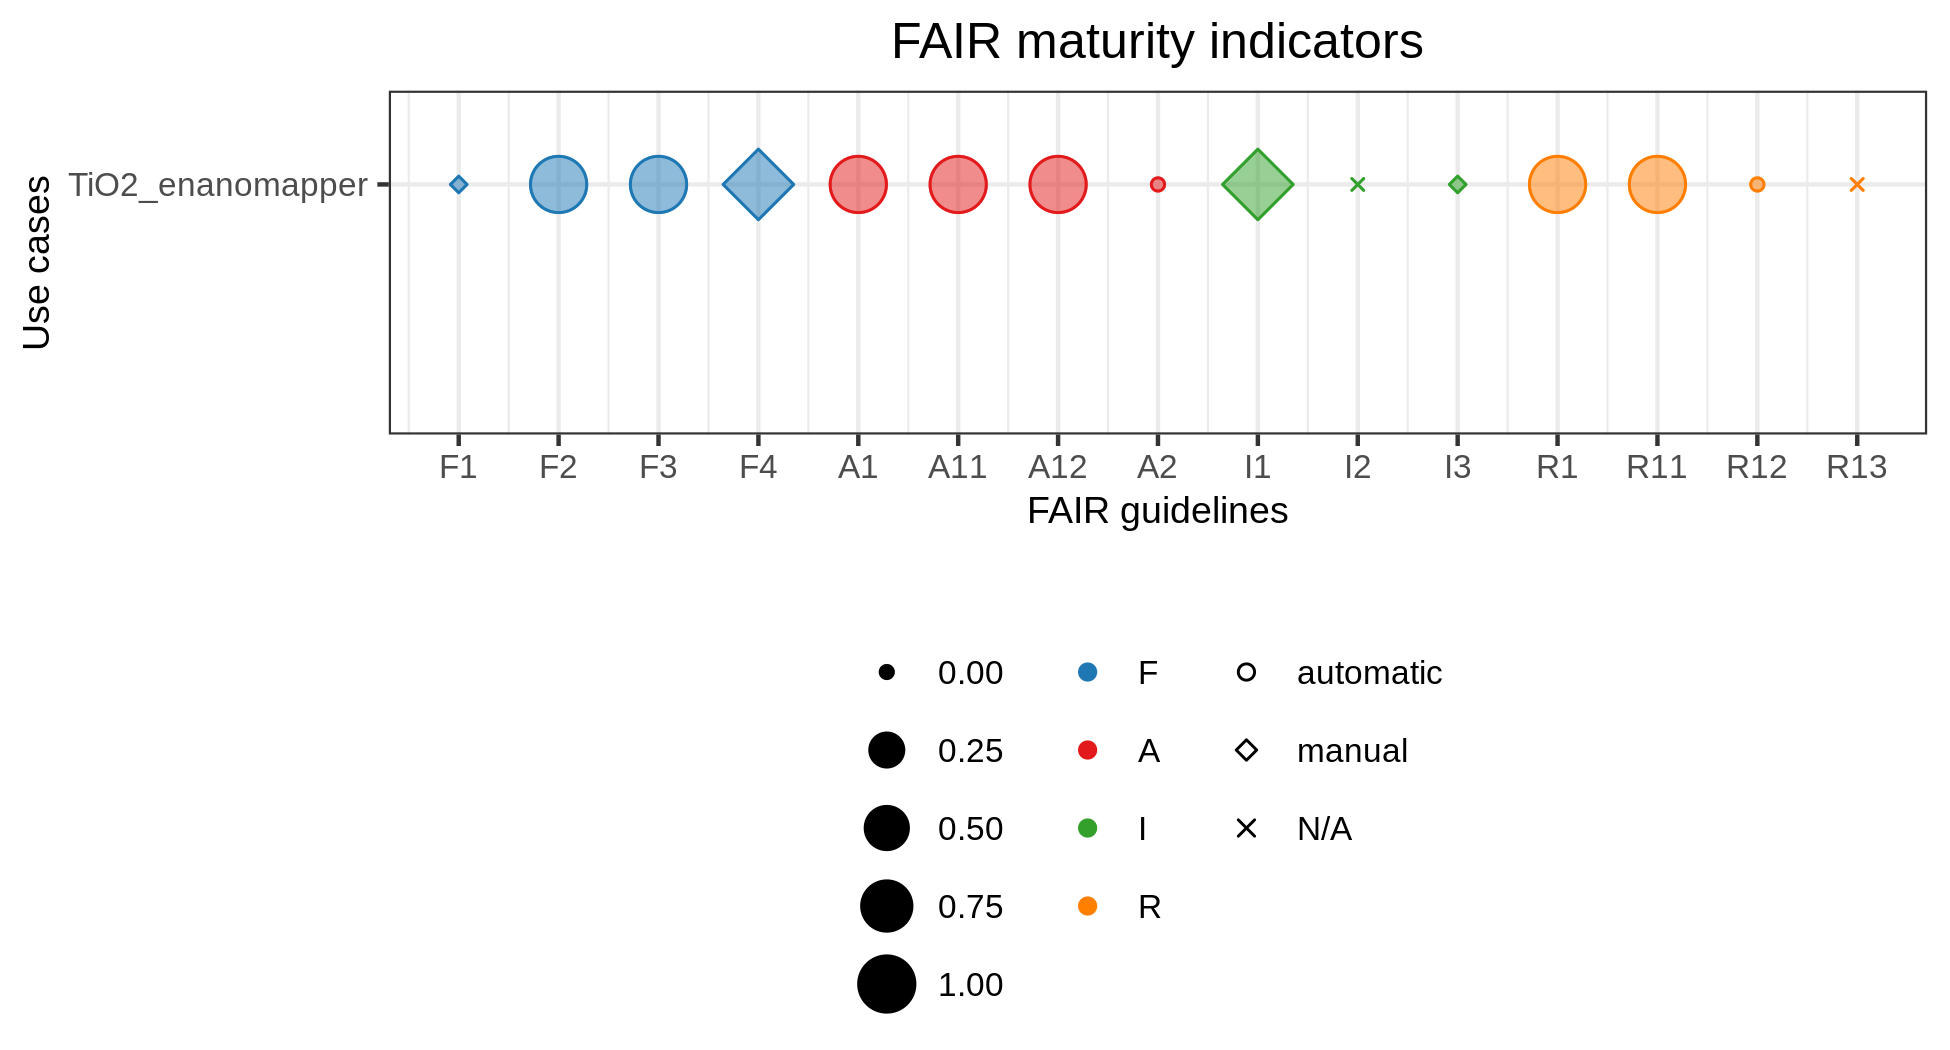

In [34]:
%%R -i df -w 6.5 -h 3.5 --units in -r 300 #-i df 

library(ggplot2)

# variables
y_values   <- seq(1, nrow(df))
y_values   <- sort(y_values, decreasing = TRUE)
n_of_cases <- ncol(df)-3
#n_of_cases <- 4
case_names <- rev(colnames(df)[1:n_of_cases])
# font size
title_text_size <- 12
axis_text_size  <- 9
tick_text_size  <- 8

# initiate graph
pl <- ggplot (data=df, aes(x=x_values1, y=y_values, color=principles, shape=retrieval_type))

# add cases in for loop
for (i in (1:n_of_cases)){

    # create a new dataframe with what needed for the current repository
    # (if one keeps indexes in geom_point, ggplot plots only the last very line - see https://stackoverflow.com/questions/18444620/set-layers-in-ggplot2-via-loop)
    gg.data <- data.frame(current_df=df[i], x_values=rep(i, nrow(df)), principles=df$principles, retrieval_type=df$retrieval_type)
   
    # change specific column name (e.g.DANSEASY) to a generic name
    colnames(gg.data)[1]<-"dataset"
    
    pl <- pl + 
          geom_point(data=gg.data, aes(x=x_values, y=y_values, size=dataset, color=principles, shape=retrieval_type)) + # add size, color, and shape
          geom_point(data=gg.data, aes(x=x_values, y=y_values, size=dataset, fill=principles, shape=retrieval_type), alpha=0.5, show.legend = FALSE) # add fill but do not show the legend (it would be the same as for color)
}

# add layers to plot
pl <- pl +
        # change shapes to squares, circles, and crosses
        scale_shape_manual(values = c(21,23,4)) +
        # background
        theme_bw() +  
        # flip x and y
        coord_flip()  +
        # axis ticks
        scale_x_reverse(limits=c(2.5,0.5), breaks=seq(n_of_cases,1,-1),  labels=c(colnames(df)[n_of_cases:1])) +  
        scale_y_reverse(limits=c(15, 1),   breaks=seq(15,1,-1), labels=df$metric_names) + 
        theme(axis.text.x = element_text(size = tick_text_size)) + 
        theme(axis.text.y = element_text(size = tick_text_size)) +
        # axis text
        xlab ("Use cases") +
        ylab ("FAIR guidelines") +
        theme(text = element_text( size = axis_text_size)) + 
        # change colors for lines
        scale_color_manual(values=c("#e31a1c", "#1f78b4", "#33a02c", "#ff7f00") ,
                           labels = c("F", "A", "I", "R"),
                           breaks = c("F", "A", "I", "R")
                          ) +  
        # change colors for fills
        scale_fill_manual(values=c("#e31a1c", "#1f78b4", "#33a02c", "#ff7f00")) +
        # title
        ggtitle("FAIR maturity indicators") +
        theme(plot.title = element_text(size = title_text_size, hjust = 0.5))  +
        # legend - colors
        theme(legend.text = element_text(size=tick_text_size), legend.key.size = unit(0.2, "cm")) + 
        labs(color="") +                             # no legend title   
        labs(size="")  +                             # no legend title 
        labs(shape="") +                             # no legend title 
        theme (legend.spacing.x = unit(0.1, "cm"),   # reduce horizontal space between legends
               legend.box = "horizontal",            # put legends next to each other
               legend.direction = "vertical",        # 
               legend.position = "bottom",           # under the graph
               legend.key.size = unit(1.3, 'lines'), # space better legend items
               legend.margin=margin(c(1,7,1,1))) +   # margin around each legend 
        guides(color = guide_legend(order=2),        # change legend order
               size  = guide_legend(order=1),
               shape = guide_legend(order=3))
        

# display
ggsave("enanomapper.png", plot = pl)

pl

In [ ]:
%%R 
# requires the package "svglite" to save as svg
#ggsave("outcome_comparison.svg", plot = last_plot(), width=6.5, height=3.5, dpi=300) # comment if used in mybinder, uncomment if used locally 

---


<a name="dependencies"></a>
## Dependencies 

In [ ]:
%reload_ext watermark
%watermark -v -m -p bs4,os,pandas,requests,xml.etree.ElementTree,io
print ("")
%watermark -u -n -t -z

In [ ]:
%%R
sessionInfo()

In [ ]:
%watermark -u -n -t -z

---

<a name="supplementary_information"></a>
## Supplementary information     

#### Metadata of the dataset in xml:

In [ ]:
for case_id in range (0, 2):

    print ("--> " + repository_name[case_id] + " :")
    pretty_print_xml(metadata_xml[case_id])
    print (" ")
    print ("---------------------------------------------------------------")

#### Metadata of the dataset in lists (no nesting):

In [ ]:
for case_id in range (0, 2):

    print ("--> " + repository_name[case_id] + " :")
    
    for a in range(0,len(metadata_list[case_id][0])):
        print (metadata_list[case_id][0][a] + ": " + metadata_list[case_id][1][a])
    print (" ")
    print ("---------------------------------------------------------------")


#### Metadata of the repositories in xml (no nesting):

In [ ]:
for case_id in range (0, 2):

    print ("--> " + repository_name[case_id] + " :")
    pretty_print_xml(re3data_repo_root[case_id])
    print (" ")
    print ("---------------------------------------------------------------")


#### Metadata of the repositories in lists (no nesting):

In [ ]:
for case_id in range (0, len(repository_name)):

    print ("--> " + repository_name[case_id] + " :")
    
    
    for a in range(0,len(re3data_metadata_list[case_id][0])):
        print (re3data_metadata_list[case_id][0][a] + ": " + re3data_metadata_list[case_id][1][a])
    print (" ")
    print ("---------------------------------------------------------------")